# 步骤1：读取和预处理数据

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# 读取CSV文件
df = pd.read_csv('users.csv', encoding='GB18030')

# 选择有用的属性，去掉'category'为NaN的行
# 'Username', 'Name', , 'url'
useful_columns = ['Company', 'Location', 'Public Repos', 'Followers', 'Following', 
                 'Created At', 'Updated At', 'Commits', 'Pull Requests', 'Issues', 'Comments', 
                 'Repositories Contributed To', 'organization']
data = df[useful_columns]
labels = df['category']

data['Created At'] = pd.to_datetime(data['Created At']).apply(lambda x: x.timestamp())
data['Updated At'] = pd.to_datetime(data['Updated At']).apply(lambda x: x.timestamp())

# 将分类数据转换为数值数据
data = pd.get_dummies(data, columns=['Company', 'Location', 'organization'])

# 填充NaN值
data.fillna(0, inplace=True)


# 划分有标签和无标签的数据
labeled_mask = labels.notna()
unlabeled_mask = ~labeled_mask

labeled_data = data[labeled_mask]
labeled_labels = labels[labeled_mask].astype(int) - 1

unlabeled_data = data[unlabeled_mask]

# 标准化数据
scaler = StandardScaler()
labeled_data = scaler.fit_transform(labeled_data)
unlabeled_data = scaler.transform(unlabeled_data)


# 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(labeled_data, labeled_labels, test_size=0.2, random_state=42)

# 转换为PyTorch张量
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.long)
unlabeled_data = torch.tensor(unlabeled_data, dtype=torch.float32)


/tmp/ipykernel_8274/1060738819.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Created At'] = pd.to_datetime(data['Created At']).apply(lambda x: x.timestamp())
/tmp/ipykernel_8274/1060738819.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Updated At'] = pd.to_datetime(data['Updated At']).apply(lambda x: x.timestamp())


In [18]:
print("Train size {}, Val size {}".format(len(y_train), len(y_val)))

Train size 64, Val size 16


# 步骤2：定义数据集和数据加载器

In [19]:
class CustomDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.labels is not None:
            return self.data[idx], self.labels[idx]
        else:
            return self.data[idx]

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
unlabeled_dataset = CustomDataset(unlabeled_data)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=False)


# 步骤3：定义模型

In [20]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# 定义模型、损失函数和优化器
input_dim = X_train.shape[1]
output_dim = len(labeled_labels.unique())

# 步骤4：训练模型

In [21]:
model = SimpleNN(input_dim, output_dim).cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 15

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        
        model.eval()
        val_loss = 0.0
        correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.cuda(), labels.cuda()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                
                _, preds = torch.max(outputs, 1)
                # print(preds)
                correct += torch.sum(preds == labels)
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct.double() / len(val_loader.dataset)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
    return model

model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)


Epoch 1/15, Loss: 1.3695, Val Loss: 1.4055, Val Acc: 0.1875
Epoch 2/15, Loss: 1.0166, Val Loss: 1.4142, Val Acc: 0.2500
Epoch 3/15, Loss: 0.7461, Val Loss: 1.4295, Val Acc: 0.1875
Epoch 4/15, Loss: 0.5543, Val Loss: 1.3795, Val Acc: 0.2500
Epoch 5/15, Loss: 0.4164, Val Loss: 1.2307, Val Acc: 0.3125
Epoch 6/15, Loss: 0.3191, Val Loss: 1.0919, Val Acc: 0.5625
Epoch 7/15, Loss: 0.2569, Val Loss: 1.0670, Val Acc: 0.6250
Epoch 8/15, Loss: 0.2277, Val Loss: 1.1066, Val Acc: 0.5625
Epoch 9/15, Loss: 0.1766, Val Loss: 1.2179, Val Acc: 0.5625
Epoch 10/15, Loss: 0.1522, Val Loss: 1.3327, Val Acc: 0.5625
Epoch 11/15, Loss: 0.1266, Val Loss: 1.3465, Val Acc: 0.5625
Epoch 12/15, Loss: 0.1041, Val Loss: 1.3432, Val Acc: 0.5625
Epoch 13/15, Loss: 0.0920, Val Loss: 1.3759, Val Acc: 0.5625
Epoch 14/15, Loss: 0.0736, Val Loss: 1.4293, Val Acc: 0.5625
Epoch 15/15, Loss: 0.0616, Val Loss: 1.4869, Val Acc: 0.5625


# 步骤5：预测无标签数据

Iteration 1/10
Epoch 1/5, Loss: 0.0061
Epoch 2/5, Loss: 0.0049
Epoch 3/5, Loss: 0.0033
Epoch 4/5, Loss: 0.0004
Epoch 5/5, Loss: 0.0002
Average confidence on unlabeled data: 0.9228
Iteration 2/10
Epoch 1/5, Loss: 0.0798
Epoch 2/5, Loss: 0.0823
Epoch 3/5, Loss: 0.0328
Epoch 4/5, Loss: 0.0150
Epoch 5/5, Loss: 0.0049
Average confidence on unlabeled data: 0.9751
Iteration 3/10
Epoch 1/5, Loss: 0.0092
Epoch 2/5, Loss: 0.0256
Epoch 3/5, Loss: 0.0330
Epoch 4/5, Loss: 0.0222
Epoch 5/5, Loss: 0.0263
Average confidence on unlabeled data: 0.9874
Iteration 4/10
Epoch 1/5, Loss: 0.0142
Epoch 2/5, Loss: 0.0479
Epoch 3/5, Loss: 0.0576
Epoch 4/5, Loss: 0.0245
Epoch 5/5, Loss: 0.0391
Average confidence on unlabeled data: 0.9906
Iteration 5/10
Epoch 1/5, Loss: 0.0029
Epoch 2/5, Loss: 0.0087
Epoch 3/5, Loss: 0.0016
Epoch 4/5, Loss: 0.0009
Epoch 5/5, Loss: 0.0007
Average confidence on unlabeled data: 0.9937
Iteration 6/10
Epoch 1/5, Loss: 0.0129
Epoch 2/5, Loss: 0.0527
Epoch 3/5, Loss: 0.0497
Epoch 4/5, Lo

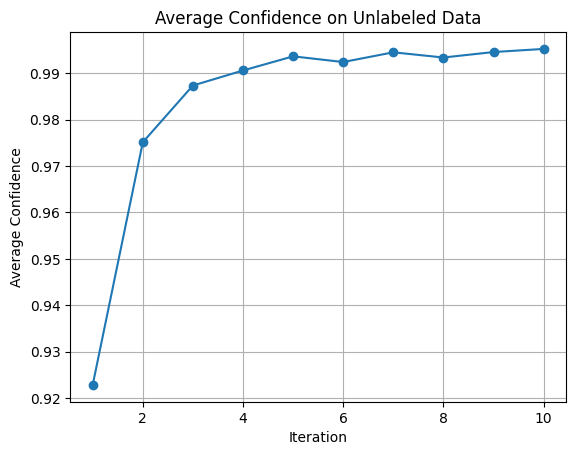

In [22]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

# 生成高置信度伪标签
def generate_high_confidence_pseudo_labels(model, unlabeled_loader, threshold=0.9):
    model.eval()
    pseudo_labels = []
    pseudo_data = []
    confidences = []
    
    with torch.no_grad():
        for inputs in unlabeled_loader:
            inputs = inputs.cuda()
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            max_probs, preds = torch.max(probs, 1)
            
            for i in range(len(max_probs)):
                if max_probs[i] > threshold:
                    pseudo_labels.append(preds[i].cpu().numpy())
                    pseudo_data.append(inputs[i].cpu().numpy())
                    confidences.append(max_probs[i].cpu().numpy())
    
    return np.array(pseudo_data), np.array(pseudo_labels), np.array(confidences)

# 创建伪标签数据加载器
def create_pseudo_loader(pseudo_data, pseudo_labels, batch_size=32):
    pseudo_data_tensor = torch.tensor(pseudo_data, dtype=torch.float32)
    pseudo_labels_tensor = torch.tensor(pseudo_labels, dtype=torch.long)
    pseudo_dataset = TensorDataset(pseudo_data_tensor, pseudo_labels_tensor)
    return DataLoader(pseudo_dataset, batch_size=batch_size, shuffle=True)

# 继续训练模型
def train_model_with_pseudo_labels(model, pseudo_loader, optimizer, criterion, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in pseudo_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(pseudo_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

# 计算无标签数据集上的置信度平均值
def compute_average_confidence(model, unlabeled_loader):
    model.eval()
    confidences = []
    
    with torch.no_grad():
        for inputs in unlabeled_loader:
            inputs = inputs.cuda()
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            max_probs, _ = torch.max(probs, 1)
            confidences.extend(max_probs.cpu().numpy())
    
    return np.mean(confidences)

# 循环添加高置信度样本
def self_training_loop(model, unlabeled_loader, optimizer, criterion, num_iterations=10, threshold=0.9, batch_size=32):
    average_confidences = []
    
    for iteration in range(num_iterations):
        print(f"Iteration {iteration+1}/{num_iterations}")
        
        # 生成高置信度伪标签
        pseudo_data, pseudo_labels, confidences = generate_high_confidence_pseudo_labels(model, unlabeled_loader, threshold)
        
        if len(pseudo_labels) == 0:
            print("No high-confidence pseudo-labels generated. Stopping early.")
            break
        
        # 创建新的数据加载器
        pseudo_loader = create_pseudo_loader(pseudo_data, pseudo_labels, batch_size)
        
        # 继续训练模型
        train_model_with_pseudo_labels(model, pseudo_loader, optimizer, criterion, num_epochs=5)
        
        # 计算并记录无标签数据集上的置信度平均值
        avg_confidence = compute_average_confidence(model, unlabeled_loader)
        average_confidences.append(avg_confidence)
        print(f'Average confidence on unlabeled data: {avg_confidence:.4f}')
        
        # 可选：更新未标记的数据集（如果有其他策略）
        # new_unlabeled_data = get_new_unlabeled_data()
        # new_unlabeled_loader = DataLoader(new_unlabeled_data, batch_size=batch_size, shuffle=False)
    
    # 绘制置信度图表
    plt.plot(range(1, len(average_confidences) + 1), average_confidences, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Average Confidence')
    plt.title('Average Confidence on Unlabeled Data')
    plt.grid(True)
    plt.show()


self_training_loop(model, unlabeled_loader, optimizer, criterion, batch_size=batch_size)

In [23]:
import torch

# 假设 val_loader 是你有标签测试数据的 DataLoader
# model 是训练后的模型
# 以下代码计算模型在测试集上的准确性

def evaluate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

# 计算模型在测试集上的准确性
accuracy = evaluate_model(model, val_loader)
print(f'Model accuracy on val set: {accuracy:.4f}')

Model accuracy on test set: 0.5625
